In [1]:
make_plot = False

##### imports

In [2]:
import csv
import numpy as np
import pandas as pd
import scipy as sp
from scipy import sparse

import time as tm
import timeit

import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
import mpld3 #interactive plot -> mpld3.enable_notebook()
from mpl_toolkits.mplot3d import Axes3D
# create custom color maps
from matplotlib import cm
plt.style.use('default')
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns

import os
from os import listdir
import glob
from tqdm import tqdm

import sklearn
import sklearn.mixture
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import phate

In [3]:
import plotly.express as px
import plotly.graph_objects as go

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf, acovf
from statsmodels.tsa.tsatools import lagmat

In [5]:
from Connectome_Template_functions import subject_data, plot_BOLD_ts, calc_FC, calc_FCs_ut, \
calc_FCs_stream_variants, calc_FCD, calc_edge_ts, calc_RSS, run_KMeans, PCA_sklearn, \
calc_FCD_states, create_2D_brain_plot

In [6]:
parameters = {'axes.labelsize': 22,
              'axes.titlesize': 22,
              'legend.fontsize': 22,
              'xtick.labelsize': 22,
             'ytick.labelsize': 22}
plt.rcParams.update(parameters)
plt.rcParams["figure.figsize"] = (10,6)

In [7]:
def mscatter(x,y,z, ax=None, m=None, **kw):
    import matplotlib.markers as mmarkers
    ax = ax or plt.gca()
    sc = ax.scatter(x,y,z,**kw)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

In [8]:
# sampling frequency of the BOLD signal
TR = 0.72

In [9]:
preprocessings = ['dicer', 'gsr', 'orig']

In [10]:
data_list, weights = subject_data(os.path.split(os.getcwd())[0], '/data/ins-amu SipEtAl22_ParamInferenceWithUnknownDynamics main study-data/101309/',
                                             'npy', '/region_names.txt', '/weights.txt', use_time=False, sampling_rate=TR)

In [11]:
N_samples, N_regions = data_list[0].shape

In [12]:
# BOLD_plot = plot_BOLD_ts(subj09_data)

### data analysis pipeline

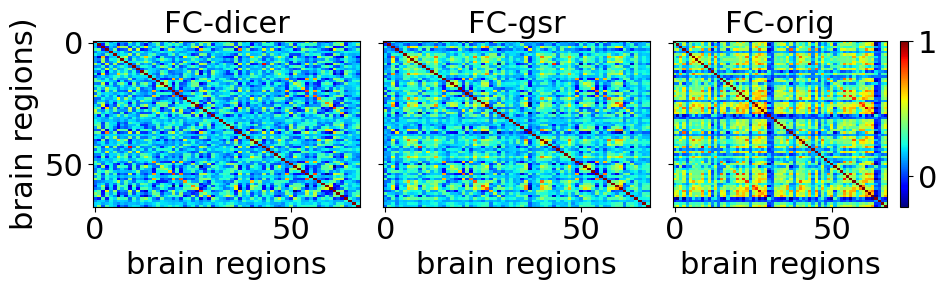

In [13]:
FC_list = calc_FC(data_list, preprocessings, plot=True)

In [14]:
FCs_ut_list, windowed_time = calc_FCs_ut(data_list, 30, use_time=False, sampling_rate=TR)

In [15]:
# samples x upper triagonal elements
FCs_ut_list[0].shape

(1171, 2278)

In [16]:
FC_stream, _ = calc_FCs_stream_variants(data_list, FCs_ut_list)

In [17]:
FC_stream[0].shape

(1171,)

In [18]:
FCDs_list = calc_FCD(data_list, FCs_ut_list)

In [19]:
%matplotlib inline
if make_plot == True:
    fig, ax = plt.subplots(1,3, sharey=True,figsize = (20,24))
    use_time = False
    if use_time == True:
        xlabel = 'windowed time'
    else:
        xlabel = 'windowed samples'

    for i in range(len(data_list)):

        im3 = ax[i].imshow(FCDs_list[i], cmap='jet', aspect='equal', interpolation='none',
                          extent=[windowed_time[0], windowed_time[-1], windowed_time[-1], windowed_time[0]])
        ax[i].set_xlabel(xlabel)
        ax[i].set_title('FCD-'+preprocessings[i])
    ax[0].set_ylabel(xlabel)#, fontsize=11)

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.82, 0.43, 0.01, 0.14])
    plt.colorbar(im3, cax=cbar_ax, shrink = 0.15);

# plt.tight_layout();

In [20]:
Enm_list, Enm_ut_list = calc_edge_ts(data_list)

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.89it/s]


##### RSS, coactivation events

In [22]:
RSS_list, RSS_95th_percentile_list, RSS_colors_strings = calc_RSS(data_list, Enm_list,
                                                                  cofluctuation_color='gold', rest_color='grey')

In [23]:
n_Enm_clusters = [2,3,4]
km_colors = ['green', 'cyan', 'brown', 'darkorange', 'purple', 'black']

In [24]:
km_Enm_labels_list, silh_Enm_avg_list, best_idx_Enm__list = run_KMeans(Enm_ut_list, n_Enm_clusters)

100%|█████████████████████████████████████████████| 3/3 [00:12<00:00,  4.15s/it]


In [27]:
if make_plot == True:
    fig, axes = plt.subplots(5, 1, sharex=True,figsize = (11,16),
                             gridspec_kw={'height_ratios': [1.5, 1.5, 10, 1.5, 3]})
    axes[0].imshow(Enm_ut_list[2].T, cmap='jet', aspect='auto', interpolation='none')
    axes[0].set_ylabel('edges')

    axes[1].imshow(data_list[2].T, cmap='jet', aspect='auto', interpolation='none')
    axes[1].set_ylabel('nodes')#, fontsize=11)

    axes[2].imshow(FCDs_list[2], cmap='jet', aspect='auto', interpolation='none', 
                  extent = [windowed_time[0], windowed_time[-1], windowed_time[-1], windowed_time[0]])
    axes[2].set_ylabel('windowed samples')#, fontsize=11)
    axes[2].set_xlabel('windowed samples')#, fontsize=11)

    for i, k in enumerate(km_Enm_labels_list[2][best_idx_Enm__list[2], :]):
        axes[3].vlines(np.arange(N_samples)[i], 0, 50, colors = km_colors[int(k)])
    axes[3].set_ylim(0,50);
    axes[3].set_xlim(0,1200);
    axes[3].tick_params(left = False, labelleft=False)
    axes[3].set_ylabel('edges \n labels \n \n')

    axes[4].hlines(RSS_95th_percentile_list[2], np.arange(N_samples)[0], np.arange(N_samples)[-1], linestyles='--', color = 'red')
    axes[4].plot(np.arange(N_samples), RSS_list[2])
    axes[4].set_ylabel('RSS')
    axes[4].set_xlabel('Samples')

    fig.align_ylabels([axes[0],axes[1],axes[2],axes[-1]])
    plt.tight_layout()
    plt.show()

#### PCA on BOLD data

In [28]:
var_expl, PCs, PCA_data = [], [],[]
for i in range(len(data_list)):
    PCA_results = PCA_sklearn(data_list[i], N_regions)
    var_expl.append(PCA_results[0])
    PCs.append(PCA_results[1]) 
    PCA_data.append(PCA_results[2])

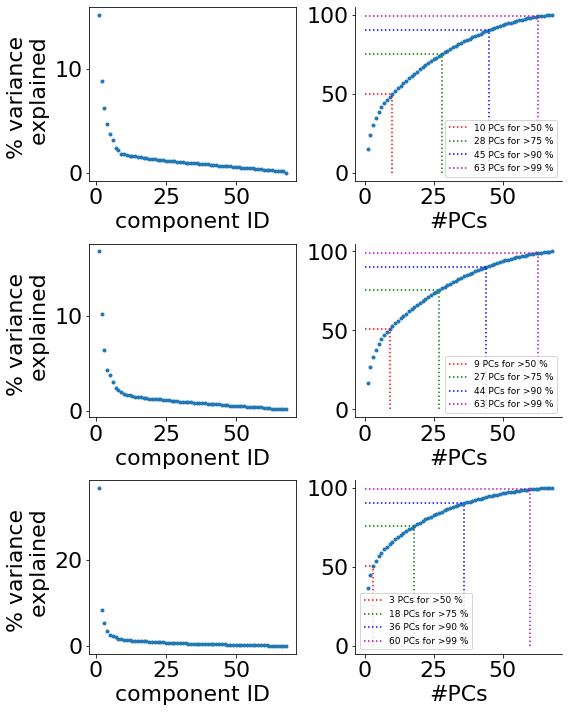

In [29]:

fig, ax = plt.subplots(len(data_list), 2, figsize = (8,10))
#                          gridspec_kw={'height_ratios': [3, 0.75, 0.75]})
for i in range(len(data_list)):
    cvar = np.zeros(var_expl[i].shape[0])
    for n in range(var_expl[i].shape[0]):
        if n == 0:
            cvar[n] = var_expl[i][n]
        else:
            cvar[n] = var_expl[i][n] + cvar[n-1]
    n_PCs = np.arange(var_expl[i].shape[0])+1
#     plt.figure(figsize=(14,7))
#     plt.subplot(121)
#     print(n_PCs, var_expl_sklearn[i]*100)
    ax[i,0].plot(n_PCs, var_expl[i]*100, ".")
    ax[i,0].set_xlabel('component ID')
    ax[i,0].set_ylabel('% variance \n explained')
#     ax[i,0].xscale("log")

    def cum_plot(cvar, selective_v):
        a = ((np.array(np.where(cvar > selective_v))).T)+1
        return a[0]

    selective_v = [0.50, 0.75, 0.90, 0.99]
    colors = ['r', 'g', 'b', 'm']

#     plt.subplot(122)
    ax[i,1].plot(n_PCs, cvar*100, ".")
    for n in range(len(selective_v)):
        ax[i,1].vlines(cum_plot(cvar, selective_v[n]),0,cvar[(cum_plot(cvar, selective_v[n]))-1]*100, linestyle="dotted", color = colors[n],
                       label = str(int(cum_plot(cvar, selective_v[n])))+' PCs for >'+str(int(selective_v[n]*100))+' %')
        ax[i,1].hlines(cvar[(cum_plot(cvar, selective_v[n]))-1]*100,0,cum_plot(cvar, selective_v[n]), linestyle='dotted', color = colors[n])
    sns.despine(right=True, ax=ax[i,1])
    # ax[i,1].set_xticks(np.arange(N_regions))
    # ax[i,0].set_xticks(np.arange(N_regions))
    ax[i,1].set_xlabel('#PCs')
    ax[i,1].legend(fontsize = '9')
    # ax[i,1].set_ylabel('% total \n variance \n explained')
plt.tight_layout()
plt.show()

In [30]:
significant_PCs = [10, 9, 4]

In [31]:
# check if the PCA data == projection of data to the PCs eigenspace
# for i in range(3):
#     print(PCA_data[0][:,i] == PCs[0][:,i][:,None].T @ data_list[0].T)

##### find PC loadings

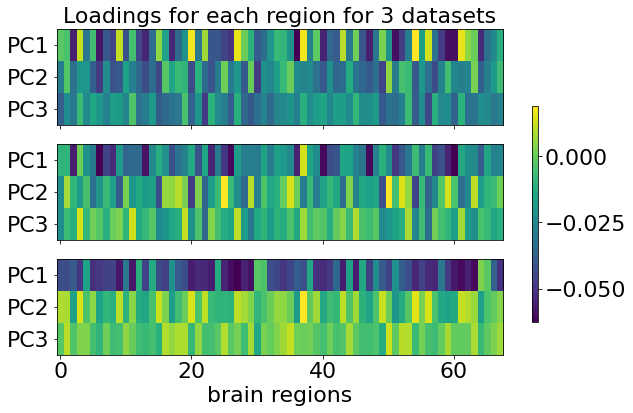

In [32]:
# loadings plot 
fig, ax = plt.subplots(3, 1, figsize = (8,6), sharex = True)
for i in range(len(data_list)):
    im_i = ax[i].imshow(np.multiply(PCs[i][:,:3],var_expl[i][:3]).T, aspect = 'auto') 
    ax[i].set_yticks(ticks = [0,1,2], labels = ["PC1","PC2","PC3"])
ax[0].set_title('Loadings for each region for {} datasets'.format(len(data_list)));
ax[2].set_xlabel('brain regions')
cbar_ax = fig.add_axes([0.95, 0.2, 0.01, 0.5])
plt.colorbar(im_i, cbar_ax)
plt.show()

In [33]:
np.multiply(PCs[0][:,0],var_expl[0][0]).T.shape

(68,)

Index(['lh-bankssts', 'lh-caudalanteriorcingulate', 'lh-caudalmiddlefrontal',
       'lh-cuneus', 'lh-entorhinal', 'lh-fusiform', 'lh-inferiorparietal',
       'lh-inferiortemporal', 'lh-isthmuscingulate', 'lh-lateraloccipital',
       'lh-lateralorbitofrontal', 'lh-lingual', 'lh-medialorbitofrontal',
       'lh-middletemporal', 'lh-parahippocampal', 'lh-paracentral',
       'lh-parsopercularis', 'lh-parsorbitalis', 'lh-parstriangularis',
       'lh-pericalcarine', 'lh-postcentral', 'lh-posteriorcingulate',
       'lh-precentral', 'lh-precuneus', 'lh-rostralanteriorcingulate',
       'lh-rostralmiddlefrontal', 'lh-superiorfrontal', 'lh-superiorparietal',
       'lh-superiortemporal', 'lh-supramarginal', 'lh-frontalpole',
       'lh-temporalpole', 'lh-transversetemporal', 'lh-insula', 'rh-bankssts',
       'rh-caudalanteriorcingulate', 'rh-caudalmiddlefrontal', 'rh-cuneus',
       'rh-entorhinal', 'rh-fusiform', 'rh-inferiorparietal',
       'rh-inferiortemporal', 'rh-isthmuscingulate',

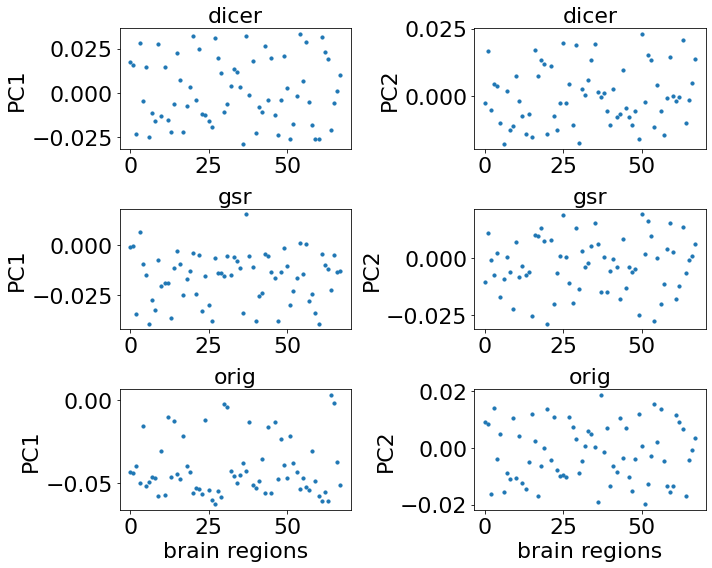

In [34]:
fig, ax = plt.subplots(3,2, figsize = (10,8))
print(data_list[0].columns)
for i in range(len(data_list)):
    for j in range(2): # for the first 2 PCs
        ax[i, j].scatter(np.arange(N_regions), np.multiply(PCs[i][:,j],var_expl[i][j]).T,
                         s = 10)
        ax[-1, j].set_xlabel('brain regions')
        ax[i, j].set_title(preprocessings[i])
        ax[i, 0].set_ylabel('PC1')
        ax[i, 1].set_ylabel('PC2')
        
plt.tight_layout()
plt.savefig('figures/PCA/PCs_vs_regions.png')

In [35]:
# for orig dataset
PCs_loadings2 = np.multiply(PCs[2][:,:3],var_expl[2][:3]).T

In [36]:
PCs_loadings2.shape

(3, 68)

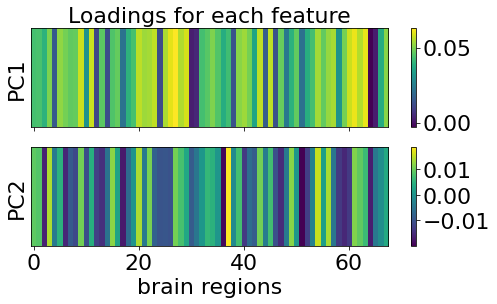

In [37]:
fig, ax = plt.subplots(2, 1, figsize = (8,4), sharex = True)
ax1, ax2 = ax.ravel()
im_PC1 = ax1.imshow(-PCs_loadings2[0,:][None,:], aspect = 'auto') 
im_PC2 = ax2.imshow(PCs_loadings2[1,:][None,:], aspect = 'auto') 

ax1.tick_params(left = False, labelleft=False)
ax1.set_title('Loadings for each feature');
# ax1.set_xlabel('brain regions')
ax1.set_ylabel('PC1')

ax2.tick_params(left = False, labelleft=False)
# ax2.set_title('Loadings for each feature');
ax2.set_xlabel('brain regions')
ax2.set_ylabel('PC2')

plt.colorbar(im_PC1, ax = ax1)
plt.colorbar(im_PC2, ax = ax2)
plt.show()

##### Combine loadings and weights for a 2D **Brain Plot**

In [38]:
colours_loadings_PC1 = im_PC1.cmap(im_PC1.norm(-PCs_loadings2[0,:][None,:]))
colours_loadings_PC2 = im_PC2.cmap(im_PC2.norm(PCs_loadings2[1,:][None,:]))

In [39]:
centersDK = pd.read_csv('centresDK.csv')
centersDK = centersDK.T

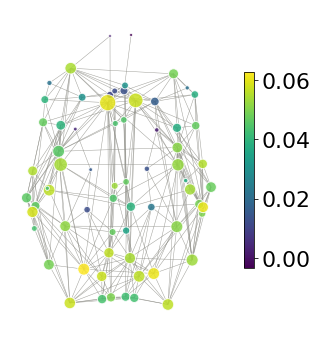

In [40]:
# weights determine the size, loadings determine the color
create_2D_brain_plot(weights, centersDK.values, threshold=100,
                    color_nodes=colours_loadings_PC1.squeeze(), mappable=im_PC1,
                    size_nodes=weights.sum(axis = 0)/100,
                   alpha_node=0.85)

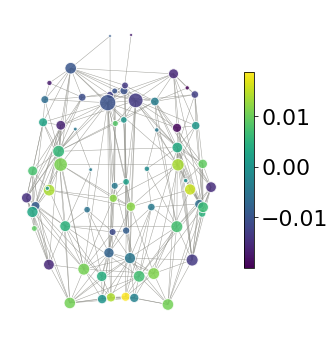

In [41]:
# weights determine the size, loadings determine the color
create_2D_brain_plot(weights, centersDK.values, threshold=100,
                    color_nodes=colours_loadings_PC2.squeeze(), mappable=im_PC2,
                    size_nodes=weights.sum(axis = 0)/100,
                   alpha_node=0.85, save_file=True)

##### PCA results combined with classes on edge series and coactivation events

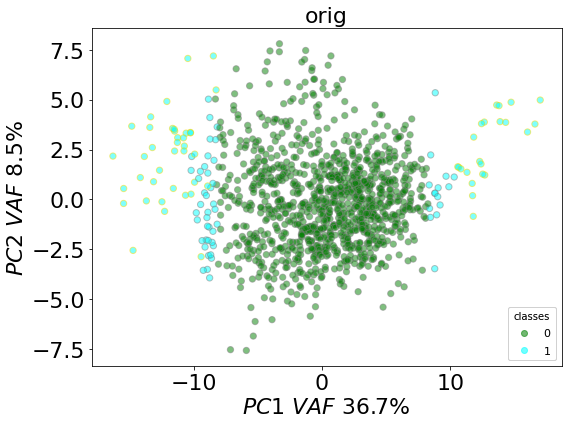

In [42]:
%matplotlib inline

fig, ax = plt.subplots(1,1, sharex='col',figsize = (8,6))

i = 2 #2nd dataset
j=0   #1st kmeans clustering
data2_PCA = ax.scatter(PCA_data[i][:,0],
                              PCA_data[i][:,1],
                              c=km_Enm_labels_list[i][j], edgecolors = RSS_colors_strings[i], s=40,
                              cmap = ListedColormap(['green', 'cyan']), 
                              alpha = 0.5)
if j == 0:

    ax.set_title(preprocessings[i])
    ax.set_ylabel(r'$PC2 \ VAF \ {}\%$'.format((100*var_expl[2][1]).round(1)))
if i == len(data_list)-1:
    ax.set_xlabel(r'$PC1 \ VAF \ {}\%$'.format((100*var_expl[2][0]).round(1)))

# produce a legend with the unique colors from the scatter
if i == len(data_list)-1:
    legend1 = ax.legend(*data2_PCA.legend_elements(),
                            loc="lower right", title="classes", prop={'size': 11})
    ax.add_artist(legend1)

plt.tight_layout()
plt.show()

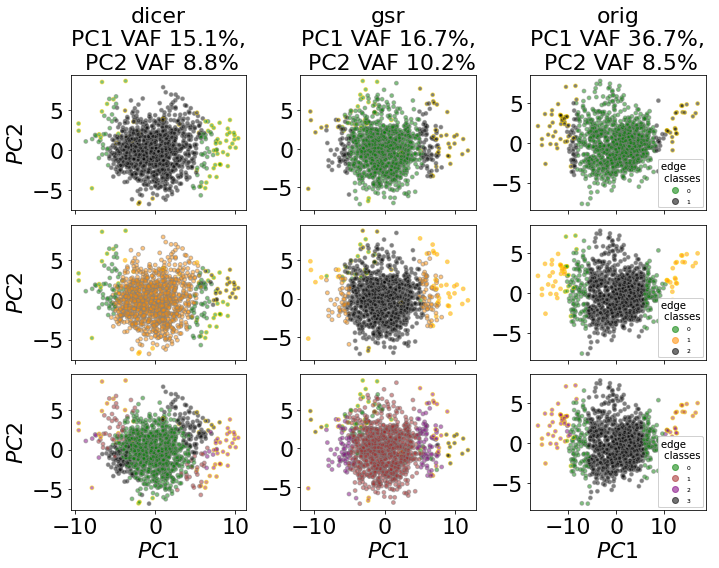

In [43]:
%matplotlib inline

fig, ax = plt.subplots(3,3, sharex='col',figsize = (10,8))

for i in range(len(data_list)):
    for j in range(len(n_Enm_clusters)):
        data_PCA = ax[j,i].scatter(PCA_data[i][:,0],
                                      PCA_data[i][:,1],
                                      c=km_Enm_labels_list[i][j], edgecolors = RSS_colors_strings[i], s=15,
                                      cmap = ListedColormap(km_colors), 
                                      alpha = 0.5)
        if j == 0:
    
            ax[j,i].set_title(preprocessings[i] + '\n PC1 VAF {}%, \n PC2 VAF {}%'.format((100*var_expl[i][0]).round(1), (100*var_expl[i][1]).round(1)))
            ax[i,j].set_ylabel(r'$PC2$')
        if i == len(data_list)-1:
            ax[i,j].set_xlabel(r'$PC1$')
            
# produce a legend with the unique colors from the scatter
        if i == len(data_list)-1:
            legend1 = ax[j,i].legend(*data_PCA.legend_elements(),
                                    loc="lower right", title="edge \n classes", prop={'size': 6})
            ax[j,i].add_artist(legend1)

plt.tight_layout()
plt.show()

#### Find FCD states

In [44]:
n_FCD_clusters = [3, 4, 5, 6]
km_FCsut_labels_list, silh_FCsut_avg_list, best_idx_FCsut_list = run_KMeans(FCs_ut_list, n_FCD_clusters)

100%|█████████████████████████████████████████████| 3/3 [00:20<00:00,  6.94s/it]


In [45]:
km_df_list, km_windowed_time_df_list, grouped_km_df_list = \
calc_FCD_states(data_list, windowed_time, 10,
                km_FCsut_labels_list, best_idx_FCsut_list, km_colors)

 33%|███████████████                              | 1/3 [00:00<00:00,  9.13it/s]

check: 23 >= 23
check: 22 >= 22
check: 20 >= 19


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 11.51it/s]


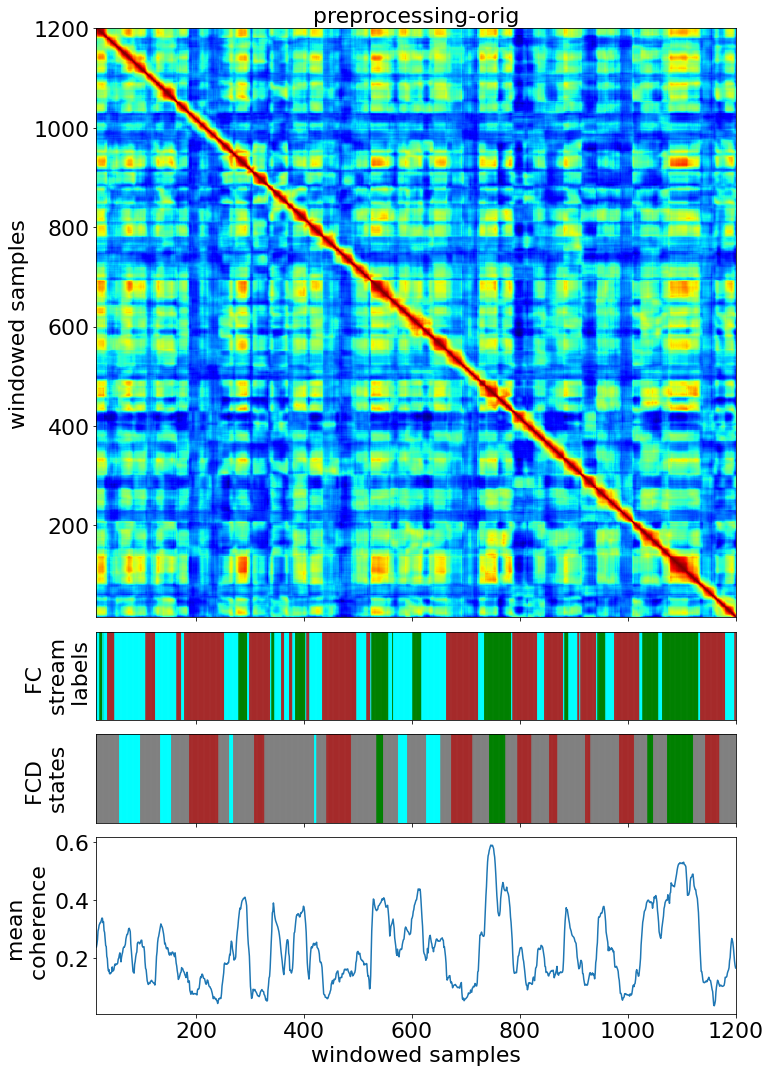

In [46]:
%matplotlib inline

fig, ax = plt.subplots(4, 1, sharex=True,figsize = (11,15),
                      gridspec_kw={'height_ratios': [10, 1.5, 1.5, 3]})#, 0.75, 0.75]})
use_time = False
if use_time == True:
    xlabel = r'$time \ [sec]$'
else:
    xlabel = 'samples'

# FCD plot
imFCD = ax[0].imshow(FCDs_list[2], cmap='jet', aspect='auto', interpolation='none',
                    extent = [windowed_time[0], windowed_time[-1],windowed_time[0], windowed_time[-1]])
ax[0].set_title('preprocessing-'+preprocessings[2])
ax[0].set_ylabel(r'windowed '+xlabel)#, fontsize=11)

# k-means clustering plot
# for j in range(len(subject_data)):
for i, k in enumerate(km_FCsut_labels_list[2][best_idx_FCsut_list[2], :]):
    ax[1].vlines(windowed_time[i], 0, 50, colors = km_colors[int(k)])
ax[1].set_ylim(0,50);
ax[1].tick_params(left = False, labelleft=False)
ax[1].set_ylabel('FC \n stream \n labels')

for i, k in enumerate(km_windowed_time_df_list[2]["kmeans colors"]):
    ax[2].vlines(windowed_time[i], 0, 50, colors = k)
# ax[1].set_xlim(0,N_FCD_upper)
ax[2].set_ylim(0,50);
ax[2].tick_params(left = False, labelleft=False)
ax[2].set_ylabel('FCD \n states \n')
# ax[2].set_title('k_means {}-'.format(element_of_n_clusters + n_FCstream_clusters[0]) + preprocessings[2])

# fc-stream plot
ax[3].plot(windowed_time, FC_stream[2])
ax[3].set_ylabel('mean \n coherence')
# ax[2].set_title('FC stream-'+preprocessings[2])
ax[3].set_xlabel('windowed ' + xlabel)#, fontsize=15)

fig.align_ylabels([ax[1], ax[2]])
plt.tight_layout()
plt.show()

##### FCD states on PCA results

In [47]:
grouped_km_df_list[2].index

MultiIndex([(-1,  'grey'),
            ( 0, 'green'),
            ( 1,  'cyan'),
            ( 2, 'brown')],
           names=['kmeans labels', 'kmeans colors'])

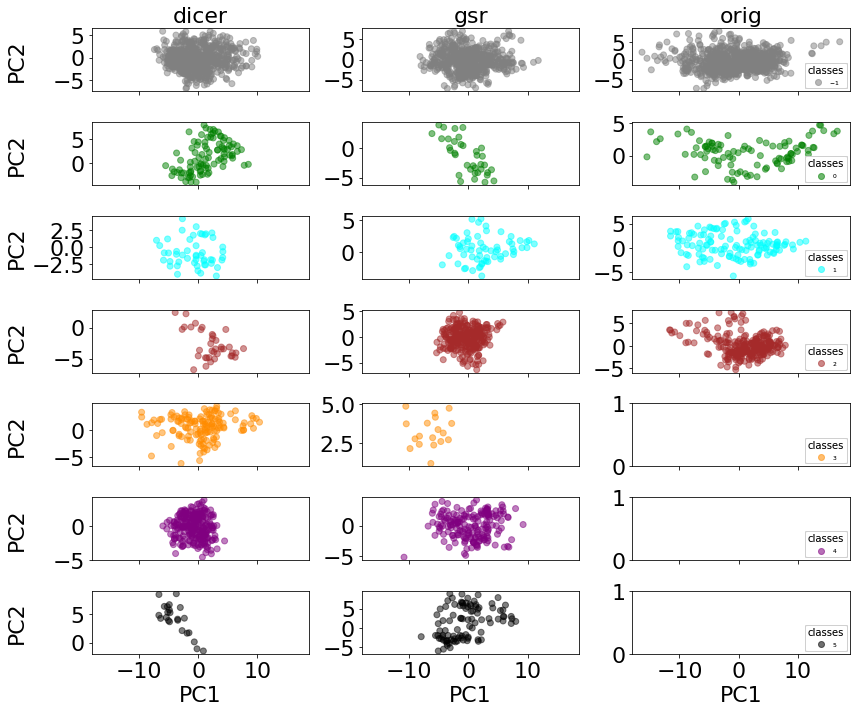

In [48]:
%matplotlib inline
t = np.arange(N_samples)
up_to_sample = t.shape[0]# - 1000 # change the size of data under inspection
fig, axes = plt.subplots(7,#grouped_km_df_list[2].index.shape[0],
                         len(data_list), sharex=True, figsize = (12,10))
colors_classes_all = [[] for _ in range(len(data_list))]
for k in range(len(data_list)):
    for i,j in zip(grouped_km_df_list[k].index, 
                   range(grouped_km_df_list[k].index.shape[0])):
        # print(j)
        colors_classes_all[k].append(grouped_km_df_list[k][i[0]].index[0])
        all_PCA = axes[j,k].scatter(PCA_data[k][:,0][grouped_km_df_list[k][i[0]].values[0]],
                          PCA_data[k][:,1][grouped_km_df_list[k][i[0]].values[0]],
                          c = km_df_list[k]['kmeans labels'].values.squeeze()[grouped_km_df_list[k][i[0]].values[0]],# edgecolors = RSS_colors_strings[:up_to_sample],
                          alpha = 0.5, cmap = ListedColormap(grouped_km_df_list[k][i[0]].index[0]))# c=km_labels[2][0], s=15, 
        legend1 = axes[j,len(data_list)-1].legend(*all_PCA.legend_elements(),
                   loc="lower right", title="classes", prop={'size': 6})
        axes[j,len(data_list)-1].add_artist(legend1)
        axes[j,0].set_ylabel('PC2')
    axes[0, k].set_title('{}'.format(preprocessings[k]))
    axes[-1, k].set_xlabel('PC1')


fig.align_ylabels(axes)
plt.tight_layout()
plt.show()

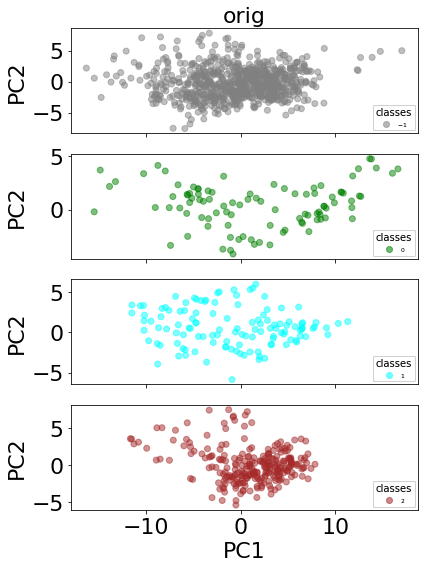

In [49]:
%matplotlib inline
t = np.arange(N_samples)
up_to_sample = t.shape[0]# - 1000 # change the size of data under inspection
fig, axes = plt.subplots(grouped_km_df_list[2].index.shape[0], 1, sharex=True, figsize = (6,8))
colors_classes = []
for i,j in zip(grouped_km_df_list[2].index, 
               range(grouped_km_df_list[2].index.shape[0])):
    colors_classes.append(grouped_km_df_list[2][i[0]].index[0])
    orig_PCA = axes[j].scatter(PCA_data[2][:,0][grouped_km_df_list[2][i[0]].values[0]],
                      PCA_data[2][:,1][grouped_km_df_list[2][i[0]].values[0]],
                      c = km_df_list[2]['kmeans labels'].values.squeeze()[grouped_km_df_list[2][i[0]].values[0]],# edgecolors = RSS_colors_strings[:up_to_sample],
                      alpha = 0.5, cmap = ListedColormap(grouped_km_df_list[2][i[0]].index[0]))# c=km_labels[2][0], s=15, 
    legend1 = axes[j].legend(*orig_PCA.legend_elements(),
               loc="lower right", title="classes", prop={'size': 6})
    axes[j].add_artist(legend1)
    axes[j].set_ylabel('PC2')
axes[0].set_title('orig')
axes[-1].set_xlabel('PC1')


fig.align_ylabels(axes)
plt.tight_layout()
plt.show()

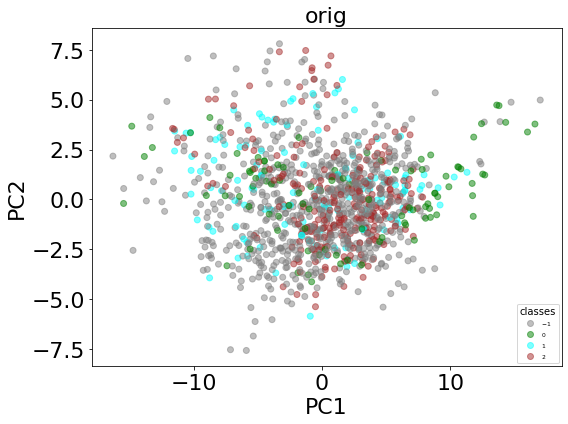

In [50]:
%matplotlib inline

up_to_sample = t.shape[0]# - 1000 # change the size of data under inspection
plt.figure(figsize = (8,6))

orig_PCA_FCD = plt.scatter(PCA_data[2][:,0][:up_to_sample],
                      PCA_data[2][:,1][:up_to_sample],
                      c = km_df_list[2]['kmeans labels'].values.squeeze()[:up_to_sample],# edgecolors = RSS_colors_strings[:up_to_sample],
                      cmap = ListedColormap(colors_classes),
                      alpha = 0.5)
plt.legend(*orig_PCA_FCD.legend_elements(),
           loc="lower right", title="classes", prop={'size': 6})
plt.title('orig')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.tight_layout()
plt.show()

#### T-PHATE

##### create $P_T$ matrix from autocorrelation function

In [51]:
aacf = []
for j in range(len(data_list)):
    temp_acf = np.zeros((N_regions,N_samples))
    for i in range(N_regions):
        temp_acf[i,:] = acovf(data_list[j].values[:,i], fft=False, nlag=N_samples-1)
    temp_acf = temp_acf.mean(axis=0)    
    aacf.append(np.convolve(temp_acf, np.ones(30)/30, mode='same'))
    

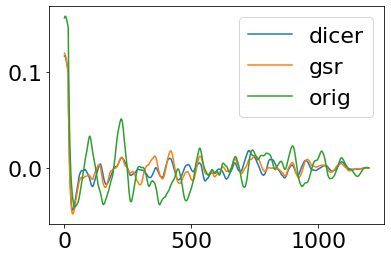

In [52]:
plt.plot(aacf[0], label = preprocessings[0])
plt.plot(aacf[1], label = preprocessings[1])
plt.plot(aacf[2], label = preprocessings[2])
plt.legend();

In [53]:
lagmax = []
for j in range(len(data_list)):
    lagmax.append(np.argwhere(np.diff(np.sign(aacf[j]))).min()+1)

In [54]:
for j in range(len(data_list)):
    aacf[j][lagmax[j]:] = 0
    aacf[j][0] = 0

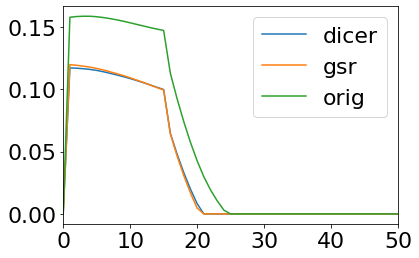

In [55]:
plt.plot(aacf[0], label = preprocessings[0])
plt.plot(aacf[1], label = preprocessings[1])
plt.plot(aacf[2], label = preprocessings[2])
plt.legend();
plt.xlim(0,50);

In [56]:
fcaacf = []
for j in range(len(data_list)):
    fcaacf.append(np.append(aacf[j][::-1][:-1], aacf[j]))

In [57]:
sparseP_T_list = []
P_T_list = []
A_matrix = np.zeros((N_samples, N_samples))
for j in range(len(data_list)):
    for i in range(N_samples):
        A_matrix[i,:] = fcaacf[j][(N_samples-1-i):(2*N_samples-1-i)]
        A_matrix[i,:] = A_matrix[i,:]/A_matrix[i,:].sum() #row-normalize the affinity matrix A
    P_T_list.append(A_matrix)
    sparseP_T_list.append(sparse.csr_matrix(P_T_list[j]))

In [58]:
sparseP_T_list[0]

<1200x1200 sparse matrix of type '<class 'numpy.float64'>'
	with 47580 stored elements in Compressed Sparse Row format>

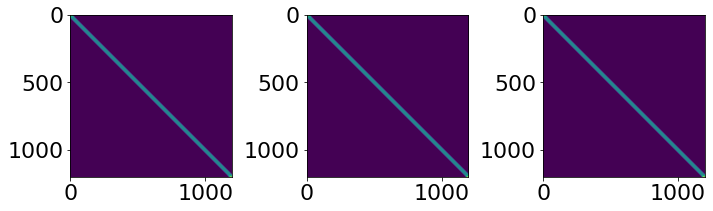

In [59]:
fig, ax = plt.subplots(1,3, figsize = (10,4))
for j in range(len(data_list)):
    ax[j].imshow(P_T_list[j])
plt.tight_layout()

##### run T-PHATE by modifying phate.phate.PHATE.graph._diff_op

In [95]:
tphate_data_3Dphate_eucl_ = []
tphate_fit = []
for i in range(len(data_list)):
    tphate_op3d_eucl_ = phate.PHATE(n_components=3, n_pca=significant_PCs[i], 
                                   knn_dist='euclidean', mds_dist='euclidean',
                                   n_jobs=-1)
    tphate_fit.append(tphate_op3d_eucl_.fit(data_list[i]))

Running PHATE on 1200 observations and 68 variables.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 0.01 seconds.
  Calculating KNN search...
  Calculated KNN search in 0.07 seconds.
  Calculating affinities...
  Calculated affinities in 0.02 seconds.
Calculated graph and diffusion operator in 0.12 seconds.
Running PHATE on 1200 observations and 68 variables.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 0.01 seconds.
  Calculating KNN search...
  Calculated KNN search in 0.06 seconds.
  Calculating affinities...
  Calculated affinities in 0.02 seconds.
Calculated graph and diffusion operator in 0.11 seconds.
Running PHATE on 1200 observations and 68 variables.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculating KNN search...
  Calculated KNN search in 0.05 seconds.
  Calculating affinities...
  Calculated affinities in 0.03 seconds.
Calculated graph and diffusion operator in 0.10 se

In [96]:
tphate_fit[0].graph._diff_op

<1200x1200 sparse matrix of type '<class 'numpy.float64'>'
	with 14320 stored elements in Compressed Sparse Row format>

In [97]:
tphate_data_3d_eucl = []
for i in range(len(data_list)):
    tphate_fit[i].graph._diff_op = tphate_fit[i].graph._diff_op @ sparseP_T_list[i]
    tphate_data_3d_eucl.append(tphate_fit[i].transform(data_list[i]))

Calculating optimal t...
  Automatically selected t = 15
Calculated optimal t in 1.38 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 0.55 seconds.
Calculating metric MDS...
Calculated metric MDS in 14.28 seconds.
Calculating optimal t...
  Automatically selected t = 16
Calculated optimal t in 1.42 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 0.50 seconds.
Calculating metric MDS...
Calculated metric MDS in 11.43 seconds.
Calculating optimal t...
  Automatically selected t = 14
Calculated optimal t in 1.10 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 0.45 seconds.
Calculating metric MDS...
Calculated metric MDS in 18.71 seconds.


In [99]:
type(tphate_fit[0].graph.diff_op)

scipy.sparse.csr.csr_matrix

In [170]:
RSS_colors_strings[1]

array(['gold', 'grey', 'grey', ..., 'grey', 'grey', 'grey'], dtype='<U4')

In [252]:
RSS_symbols = []
for i in range(len(data_list)):
    temp = np.char.replace(RSS_colors_strings[i], 'grey', 'circle')
    temp = np.char.replace(temp, 'gold', 'x')
    RSS_symbols.append(temp)

In [253]:
RSS_symbols[1]

array(['x', 'circle', 'circle', ..., 'circle', 'circle', 'circle'],
      dtype='<U6')

In [255]:
fig = go.Figure(data=[go.Scatter3d(x=tphate_data_3d_eucl[2][:,0],
                                   y=tphate_data_3d_eucl[2][:,1],
                                   z=tphate_data_3d_eucl[2][:,2],
                                   
                                   # mode='markers',
                                   marker=dict(
                                        size=3,
                                       symbol = RSS_symbols[2],
                                        color=km_df_list[2]["kmeans colors"],# set color to an array/list of desired values
                                        colorscale='Viridis',   # choose a colorscale
                                        opacity=0.5,
                                   line=dict(color = RSS_colors_strings[2], width=0.05)),
                                  line=dict(width = 0, color = 'grey', dash = 'solid'))])
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000,)
fig.show()

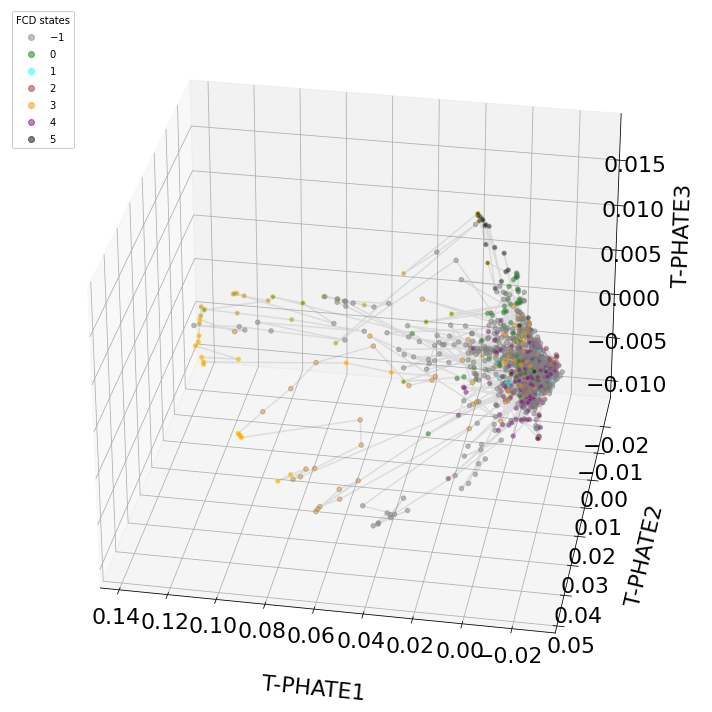

In [265]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(projection='3d')

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
# for m, zlow, zhigh in [('o', -50, -25), ('^', -30, -5)]:
phate_time_3d_plot = ax.scatter(tphate_data_3d_eucl[0][:,0],
                                    tphate_data_3d_eucl[0][:,1],
                                    tphate_data_3d_eucl[0][:,2],
                                    c=km_df_list[0]["kmeans labels"], edgecolors = RSS_colors_strings[0],
                                    # m= RSS_symbols_matplotlib[0],
                                    cmap=ListedColormap(colors_classes_all[0]),
                                    s=20, alpha = 0.5)
ax.plot3D(tphate_data_3d_eucl[0][:,0],
         tphate_data_3d_eucl[0][:,1],
         tphate_data_3d_eucl[0][:,2],
         c='grey',
         alpha = 0.2)

legend1 = ax.legend(*phate_time_3d_plot.legend_elements(),
                        loc="upper left", title="FCD states", prop={'size': 10},
                      framealpha = 1)

ax.set_xlabel('T-PHATE1', labelpad=30.5)
ax.set_ylabel('T-PHATE2', labelpad=30.5)
ax.set_zlabel('T-PHATE3', labelpad=30.5)

# ax.yaxis._axinfo['label']['space_factor'] = 50.0

plt.tight_layout()
ax.view_init(30, 100)

plt.show()